# Preamble

In [1]:
%matplotlib widget

import os
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic
from scipy.special import hyp2f1
from sympy import init_printing, init_session

plt.style.use(analytic)
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val_outside = alpha0*f27lc(alpha0, 2)
f2val_outside = alpha0*f31lc(alpha0, 2)

IPython console for SymPy 1.11.1 (Python 3.11.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



# Poisson Bracket

In [2]:
class PoissonBracket:
    def __init__(self, q, p):
        """
        q : list of canonical coordinates
        p : list of canonical momenta
        """
        self.dim = len(q)
        if len(p) != self.dim:
            raise Warning("Mismatch in canonical conjugate pair dimensions.")
        self.q = q
        self.p = p
    def __call__(self, f, g):
        """
        f, g : Functions of canonical conjugate pairs p, q
        """
        bracket = 0
        for i in range(self.dim):
            bracket += f.diff(self.p[i])*g.diff(self.q[i]) - g.diff(self.p[i])*f.diff(self.q[i])
        return(bracket)

# Symbols

In [3]:

f1, f2, f3, f4, tau, l, pom, pom_p, g, om, om_p = sm.symbols(
    "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma omega omega_p"
)
a, a_p, e, e_p, n, n_p, m_p, mu_p, L, G, Gconst, M, j = sm.symbols(
    "a a_p e e_p n n_p m_p mu_p Lambda Gamma G M j", positive=True
)
X, Y, Te, Tm = sm.symbols("X Y T_e T_m")


# Canonical variables and canonical transformations

In [4]:
def to_canonical(expr):
    return expr.subs({a: L**2, e: sqrt(2 * G / L), pom: -g})


def to_orbelts(expr):
    # This uses the approximation G=1/2*L*e^2
    return expr.subs({g: -pom, G: Rational(1, 2) * L * e**2, L: sqrt(a)})


def is_solve_multiple(sol):
    if len(sol) > 1:
        print(
            f"Solve for coordinate/momentum is multiple... {sol}, choosing the first solution."
        )
    return sol[0]


def F2_canTran(H, F2, q, P, Q, p, t):
    """
    F2: expression for generating function F_2(q,P)

    q : list of old canonical coordinates
    P : list of new canonical momenta

    Q : list of new canonical coordinates
    p : list of old canonical momenta
    """
    N = len(q)

    for var in [P, Q, p]:
        if len(var) != N:
            raise Warning("Must have same number of new and old variables.")

    Q_qP = []
    p_qP = []
    for i in range(len(q)):
        Q_qP += [F2.diff(P[i])]
        p_qP += [F2.diff(q[i])]

    P_Qp = []
    q_Qp = []
    for i in range(N):
        sol = solve([p[i] - p_qP[i], Q[i] - Q_qP[i]], [q[i], P[i]])
        try:
            q_Qp += [sol[q[i]]]
            P_Qp += [sol[P[i]]]
        except TypeError:
            q_Qp += [is_solve_multiple(sol)[0]]
            P_Qp += [is_solve_multiple(sol)[1]]

    p_QP = []
    q_QP = []
    for i in range(N):
        sol = solve(p[i] - p_qP[i].subs(q[i], q_Qp[i]), p[i])
        p_QP += [is_solve_multiple(sol)]

        sol = solve(q[i] - q_Qp[i].subs(p[i], p_qP[i]), q[i])
        q_QP += [is_solve_multiple(sol)]

    Q_qp = []
    P_qp = []
    for i in range(N):
        sol = solve(Q[i] - Q_qP[i].subs(P[i], P_Qp[i]), Q[i])
        Q_qp += [is_solve_multiple(sol)]

        sol = solve(P[i] - P_Qp[i].subs(Q[i], Q_qP[i]), P[i])
        P_qp += [is_solve_multiple(sol)]

    new_H = H.copy() + F2.diff(t)
    coords = {}
    for i in range(N):
        new_H = new_H.subs({q[i]: q_QP[i], p[i]: p_QP[i]})
        coords[q[i]] = q_QP[i]
        coords[p[i]] = p_QP[i]
        coords[Q[i]] = Q_qp[i]
        coords[P[i]] = P_qp[i]
    

    return coords, new_H

# Outer TP Hamiltonian

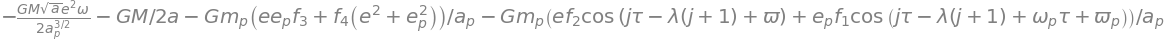

In [5]:
H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f2 * sm.cos((j + 1) * l - j * tau - pom)
        + e_p * f1 * sm.cos((j + 1) * l - j * tau - pom_p - om_p * tau)
    )
    - (Gconst * m_p / a_p * (f3 * e * e_p + f4 * (e**2 + e_p**2)))
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (
    (calH / H_scale_factor)
    .subs(m_p, mu_p * M)
    .simplify()
    .expand()
    .subs({f3: 0, f4: 0})
    #.subs(a, a * a_p)
)
display(calH)

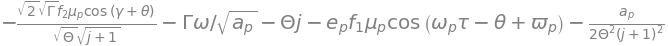

In [6]:
H = to_canonical(calH)
th, Th = symbols("theta Theta")
genFunc = Th * ((j + 1) * l - j * tau)
coords_thTh, H1 = F2_canTran(H, genFunc, [l], [Th], [th], [L], tau)
H1 = H1.simplify()
display(H1)

In [7]:
X, Y = symbols("X Y")
PB = PoissonBracket([g], [G])
X_gG = sqrt(2*G)*sin(g)
Y_gG = sqrt(2*G)*cos(g)
# PB(momentum,coordinate) = 1, 0 otherwise
display(PB(Y_gG, X_gG).simplify())
#sol =  solve([X-X_gG,Y-Y_gG],[g, G])
#g_XY = sol[0][0]
#G_XY = sol[0][1]
g_XY = atan2(X,Y)
G_XY = Rational(1,2)*(X**2+Y**2)
display(Eq(X,X_gG))
display(Eq(Y,Y_gG))

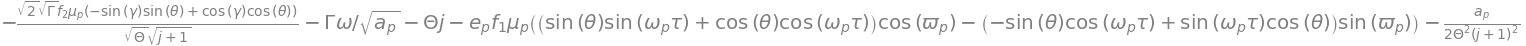

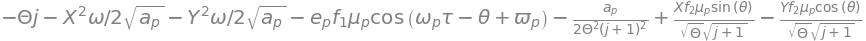

In [8]:
H2 = expand_trig(H1)
display(H2)
H_XYthTh = H2.subs(
    {
        sin(g): X / sqrt(2 * G),
        cos(g): Y / sqrt(2 * G),
        G: Rational(1, 2) * (X**2 + Y**2),
    }
).simplify()
display(H_XYthTh)

## Dissipation

In [9]:
adot_dis = -a/Tm - 2*a*e**2/Te
edot_dis = -e/Te
display(adot_dis,edot_dis)

In [10]:
coords_thTh[Th]

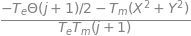

In [11]:
Thdot_dis = to_canonical(to_orbelts(coords_thTh[Th]).diff(a)*adot_dis).subs({G: G_XY, L: coords_thTh[L]}).simplify()
display(Thdot_dis)

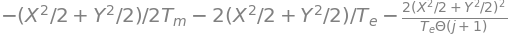

In [12]:
Gdot_dis = (
    to_canonical(
        (
            (Rational(1, 2) * sqrt(a) * e**2).diff(e) * (edot_dis)
            + (Rational(1, 2) * sqrt(a) * e**2).diff(a) * (adot_dis)
        ).simplify()
    )
    .simplify()
    .subs({G: G_XY, L: coords_thTh[L]})
)

display(Gdot_dis)

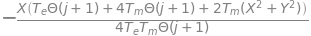

In [13]:
Xdot_dis = (X_gG.diff(G) * Gdot_dis).subs(
    {
        sin(g): X / sqrt(2 * G),
        cos(g): Y / sqrt(2 * G),
        G: Rational(1, 2) * (X**2 + Y**2),
    }
).simplify()
Xdot_dis

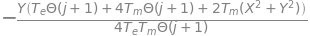

In [14]:
Ydot_dis = (Y_gG.diff(G) * Gdot_dis).subs(
    {
        sin(g): X / sqrt(2 * G),
        cos(g): Y / sqrt(2 * G),
        G: Rational(1, 2) * (X**2 + Y**2),
    }
).simplify()
Ydot_dis

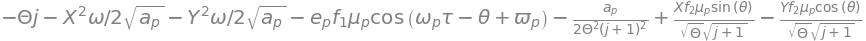

In [15]:
H_XYthTh

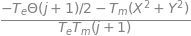

In [16]:
Thdot_dis

In [17]:
Pv = sqrt(1.31037069710445)/3
H = 1/2/Pv**2/9 - Pv*2
print(H)
print(-0.1*f1val_outside*1e-3/(-1/9/Pv**2 - 2)*6)

-0.381571414184445
-0.000335603535758360


In [18]:
1.31037069710445+0.000439765039102399

In [19]:
print(latex(H_XYthTh))

- \Theta j - \frac{X^{2} \omega}{2 \sqrt{a_{p}}} - \frac{Y^{2} \omega}{2 \sqrt{a_{p}}} - e_{p} f_{1} \mu_{p} \cos{\left(\omega_{p} \tau - \theta + \varpi_{p} \right)} - \frac{a_{p}}{2 \Theta^{2} \left(j + 1\right)^{2}} + \frac{X f_{2} \mu_{p} \sin{\left(\theta \right)}}{\sqrt{\Theta} \sqrt{j + 1}} - \frac{Y f_{2} \mu_{p} \cos{\left(\theta \right)}}{\sqrt{\Theta} \sqrt{j + 1}}


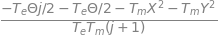

In [20]:
Thdot_dis.expand().cancel().simplify(deep=True)

# Test particle outside,  $|\omega_p|>0$, $\omega=0$

In [21]:
def orb_elts_from_integration(integration):
    y = integration.y
    X_vals = y[0, :].astype(float)
    Y_vals = y[1, :].astype(float)
    th_vals = y[2, :].astype(float) % (2 * np.pi)
    th_vals = th_vals - 2 * np.pi * (th_vals > np.pi)
    Th_vals = y[3, :].astype(float)
    g_func = lambdify([X, Y], g_XY)
    G_func = lambdify([X, Y], G_XY)
    a_func = lambdify(Th, a_Th)
    g_vals = g_func(X_vals, Y_vals)
    G_vals = G_func(X_vals, Y_vals)
    a_vals = a_func(Th_vals)
    return (
        integration.t,
        -g_vals,
        np.sqrt(2 * G_vals / np.sqrt(a_vals)),
        a_vals,
        th_vals,
    )

In [22]:
1.78*np.sqrt(500/1e6)

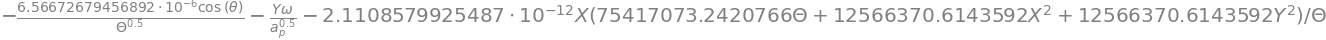

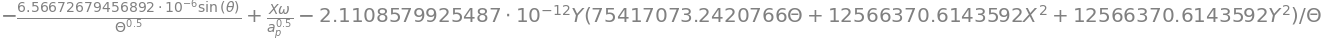

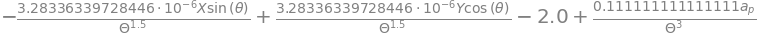

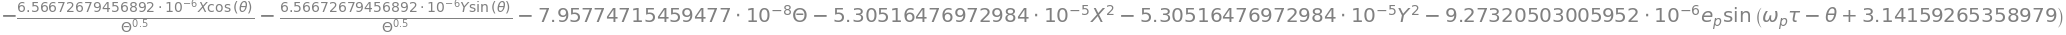

In [23]:
qval = 6e-6
def plugin(expr):
    return expr.subs(
        {
            f1: f1val_outside,
            f2: f2val_outside,
            mu_p: qval,
            j: 2,
            Te: 1e3* 2 * np.pi,
            Tm: 1e6 * 2 * np.pi,
            pom_p: np.pi,
        }
    ).evalf()


H_eom = H_XYthTh


Xdot = plugin(H_eom.diff(Y) + Xdot_dis)
Ydot = plugin(-H_eom.diff(X) + Ydot_dis)
thdot = plugin(H_eom.diff(Th))
Thdot = plugin(-H_eom.diff(th) + Thdot_dis)
display(Xdot, Ydot, thdot, Thdot)

Th_a = plugin(to_orbelts(coords_thTh[Th]))
a_Th = plugin(to_orbelts(coords_thTh[L])) ** 2
initVals = [0, 0, 0, Th_a.subs(a, 1.4)]

In [24]:
event1 = float(Th_a.subs(a, 1.2))
event2 = float(Th_a.subs(a, 2.))
tspan = (0, 2*np.pi * 1e6)
t_eval = np.linspace(tspan[0], tspan[1], 100000)


def f(t, Y):
    return Y[3] - event1


def fp(t, Y):
    return Y[3] - event2


f.terminal = True
fp.terminal = True



In [25]:
def run(ompval, omval, epval):
    Xdot_prec = Xdot.subs({om: omval, om_p: ompval, e_p: epval})
    Ydot_prec = Ydot.subs({om: omval, om_p: ompval, e_p: epval})
    thdot_prec = thdot.subs({om: omval, om_p: ompval, e_p: epval})
    Thdot_prec = Thdot.subs({om: omval, om_p: ompval, e_p: epval})

    lhs = lambdify(
        [a_p, tau, X, Y, th, Th], [Xdot_prec, Ydot_prec, thdot_prec, Thdot_prec]
    )

    def LHS(t, Y):
        return lhs(1, t, *Y)

    integration = sp.integrate.solve_ivp(
        LHS,
        tspan,
        initVals,
        # atol=1e-9,
        rtol=1e-9,
        t_eval=t_eval,
        events=[f, fp],
        method="DOP853",
    )
    return integration

In [26]:
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle

In [27]:
def solve_ivp(params):
    ind, ompval, omval, epval = params[0], params[1], params[2], params[3]
    print(ind)
    sol = run(ompval, omval, epval)
    t_int, pom_int, e_int, a_int, th_int = orb_elts_from_integration(sol)
    data = {}
    data["t"] = t_int
    data["pom"] = pom_int
    data["e"] = e_int
    data["a"] = a_int
    data["th"] = th_int
    events = sol.t_events
    return (data, params, events)

In [28]:
params = (0,0.0,0,0.03)
sol, ps, evs = solve_ivp(params)

0


In [29]:
epvals = np.linspace(0, 0.025, 20)
#ompvals = np.zeros(1)
ompvals = np.zeros(61)
ompvals[:30] = -np.flip(np.logspace(-6, -2, 30))
ompvals[31:] = np.logspace(-6, -2, 30)
jobs = []
for i, epval in enumerate(epvals):
    for k, ompval in enumerate(ompvals):
        jobs = jobs + [(61*i+k, ompval, 0., epval)]
        #jobs = jobs + [(1*i+k, ompval, 0., epval)]
print(len(jobs))
print(len(ompvals))
print(jobs)

1220
61
[(0, -0.01, 0.0, 0.0), (1, -0.007278953843983146, 0.0, 0.0), (2, -0.005298316906283708, 0.0, 0.0), (3, -0.0038566204211634724, 0.0, 0.0), (4, -0.0028072162039411755, 0.0, 0.0), (5, -0.0020433597178569417, 0.0, 0.0), (6, -0.0014873521072935117, 0.0, 0.0), (7, -0.001082636733874054, 0.0, 0.0), (8, -0.0007880462815669912, 0.0, 0.0), (9, -0.0005736152510448681, 0.0, 0.0), (10, -0.00041753189365604, 0.0, 0.0), (11, -0.0003039195382313198, 0.0, 0.0), (12, -0.0002212216291070448, 0.0, 0.0), (13, -0.00016102620275609394, 0.0, 0.0), (14, -0.00011721022975334806, 0.0, 0.0), (15, -8.531678524172815e-05, 0.0, 0.0), (16, -6.210169418915616e-05, 0.0, 0.0), (17, -4.520353656360241e-05, 0.0, 0.0), (18, -3.290344562312671e-05, 0.0, 0.0), (19, -2.395026619987486e-05, 0.0, 0.0), (20, -1.7433288221999873e-05, 0.0, 0.0), (21, -1.2689610031679234e-05, 0.0, 0.0), (22, -9.236708571873865e-06, 0.0, 0.0), (23, -6.723357536499335e-06, 0.0, 0.0), (24, -4.893900918477499e-06, 0.0, 0.0), (25, -3.56224789026

In [ ]:
executors_solve_ivp = get_reusable_executor(max_workers=60)
results = list(executors_solve_ivp.map(solve_ivp, jobs))

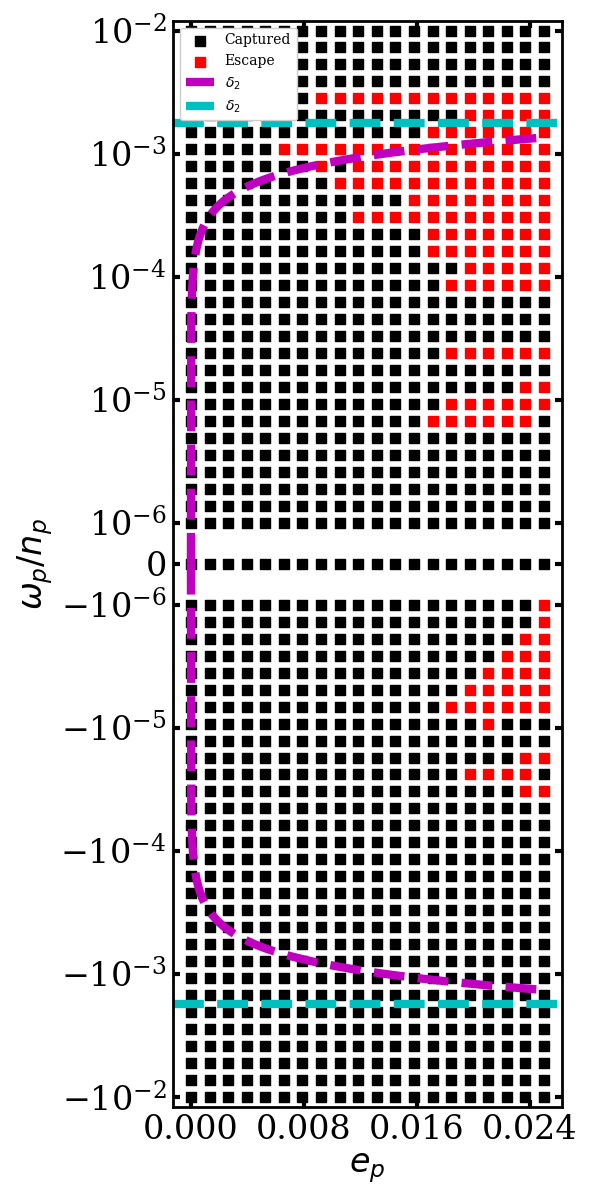

/home/astrosun/jtlaune/opt/miniconda3/envs/py311/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  self.manager.handle_json(content)


In [33]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots(figsize=(6, 12))
fig.subplots_adjust(left=0.4)

trapit = 0
escit = 0
exit = 0

for result in results:
    evs = result[2]
    ps = result[1]
    trapped = True
    for ev in evs:
        if len(ev) > 0:
            trapped = False
    if trapped:
        if trapit == 0:
            ax.scatter(ps[3], ps[1], c="k", s=50, marker="s",label="Captured")
            trapit += 1
        else:
            ax.scatter(ps[3], ps[1], c="k", s=50, marker="s")
        #ax.text(ps[3], ps[1], ps[0], fontsize=10, c="c")
    else:
        if escit == 0:
            ax.scatter(ps[3], ps[1], c="r", s=50, marker="s",label="Escape")
            escit += 1
        else:
            ax.scatter(ps[3], ps[1], c="r", s=50, marker="s")
        #ax.text(ps[3], ps[1], ps[0], fontsize=10, c="m")

a00 = (3 / 2) ** (2.0 / 3)

eps = np.linspace(epvals[0], 0.025, 1000)
d1 = (
    1.5
    * 1.5
    * 4
    * np.sqrt(2 / 3 * eps * np.abs(f1val_outside) * qval)
    / 3 ** (2 / 3)
    / 2 ** (1 / 3)
)
d2 = (
    3
    / a00**0.5
    / 3 ** (2 / 3)
    * (8 / 3 * a00**2 * np.abs(f2val_outside) * qval) ** (2.0 / 3)
)
#ax.plot(eps, d1+d2, c="m", lw=6, ls="--")
ax.plot(eps, d1, c="m", lw=6, ls="--",label=r"$\delta_2$")
ax.axhline(y= d2, c="c", lw=6, ls="--",label=r"$\delta_2$")
ax.plot(eps, -d1, c="m", lw=6, ls="--" )
ax.axhline(y= -d2, c="c", lw=6, ls="--")

ax.set_xlabel(r"$e_p$")
ax.set_ylabel(r"$\omega_p/n_p$")
ax.legend(loc="upper left",fontsize=10,framealpha=1)

ax.xaxis.set_major_locator(ticker.MaxNLocator(4))

ax.set_ylim(-0.012, 0.012)
ax.set_yscale("symlog", linthresh=1e-6, linscale=0.3)
fig.tight_layout()

om_p= -1.2689610031679234e-05
e_p= 0.017105263157894738
814


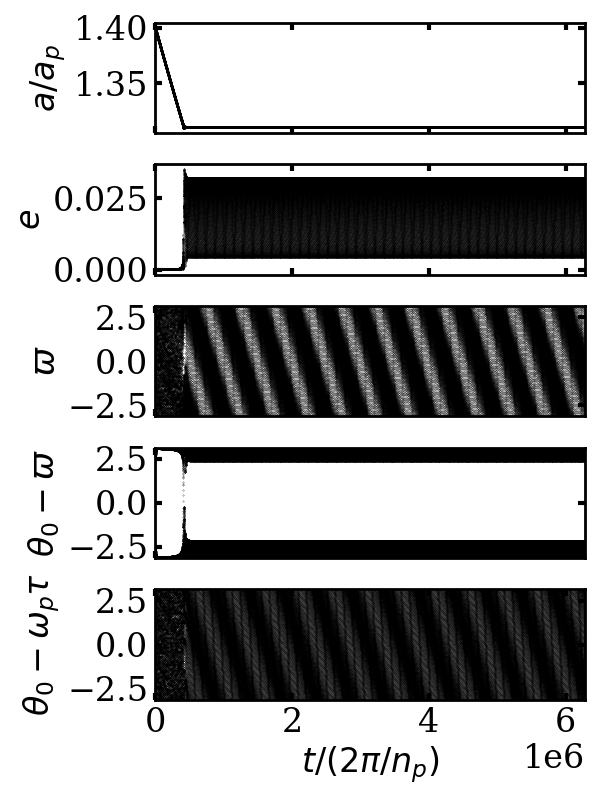

In [32]:
sel = 814
#sel = 406
#sel = 394
for i, result in enumerate(results):
    ps = result[1]
    if ps[0] == sel:
        ind = i
        print("om_p=",ps[1])
        print("e_p=",ps[3])
print(ind)

sol = results[int(ind)][0]

mpl.rcParams["lines.markersize"] = 0.2
with mpl.rc_context(analytic):
    fig, ax = plt.subplots(5, figsize=(6, 8))
fig.subplots_adjust(left=0.2)
for axis in ax[2:]:
    axis.set_ylim(-np.pi, np.pi)
for axis in ax[:-1]:
    axis.xaxis.set_ticklabels([])
for axis in ax:
    axis.set_xlim((sol["t"][0], sol["t"][-1]))


#ax[0].twinx().scatter(sol["t"], (sol["a"])**(3/2),c="orange")
ax[0].scatter(sol["t"], sol["a"],c="k")
ax[1].scatter(sol["t"], sol["e"],c="k")
ax[2].scatter(sol["t"], sol["pom"],c="k")
th_0 = (sol["th"] - sol["pom"]) % (2 * np.pi)
th_0 = th_0 - 2 * np.pi * (th_0 > np.pi)
ax[3].scatter(sol["t"], th_0,c="k")
th_p = (sol["th"] ) % (2 * np.pi)
th_p = th_p - 2 * np.pi * (th_p > np.pi)
ax[4].scatter(sol["t"], th_p,c="k")

ax[0].set_ylabel(r"$a/a_p$")
ax[1].set_ylabel(r"$e$")
ax[2].set_ylabel(r"$\varpi$")
ax[3].set_ylabel(r"$\theta_0 - \varpi$")
ax[4].set_ylabel(r"$\theta_0 - \omega_p \tau$")

ax[4].ticklabel_format(axis="x",scilimits=(0,0))

ax[4].set_xlabel(r"$t/(2\pi/n_p)$")
fig.tight_layout()

In [108]:
sel = 300
for i, result in enumerate(results):
    ps = result[1]
    if ps[0] == sel:
        ind = i
print(ind)

sol = results[int(ind)][0]
ps = results[int(ind)][1]

a0 = (3 / 2) ** (2.0 / 3)
print(a0)
Th_a.subs(a, a0)

H_plot = (
    H_eom.subs({X: X_gG, Y: Y_gG})
    .simplify()
    .subs(
        {
            om_p: ps[1],
            om: ps[2],
            e_p: ps[3],
            a_p: 1,
            f2: f2val_outside,
            mu_p: 3e-6,
            pom_p: 0,
            f1: 0,
            j: 2,
            Th: Th_a,
        }
    )
).evalf()

300
1.3103706971044482


In [109]:
x = symbols("x")
eq0 = H_plot.subs({G: 0.5 * sqrt(a) * e**2}).subs({e: (3e-6)**(1./3)}).subs(
    g, x - th
) - H_plot.subs(
    {
        a: a0,
        th: -g + pi / 2,
    }
)
eq = lambdify([x,a],eq0)

756
-4.893900918477499e-05


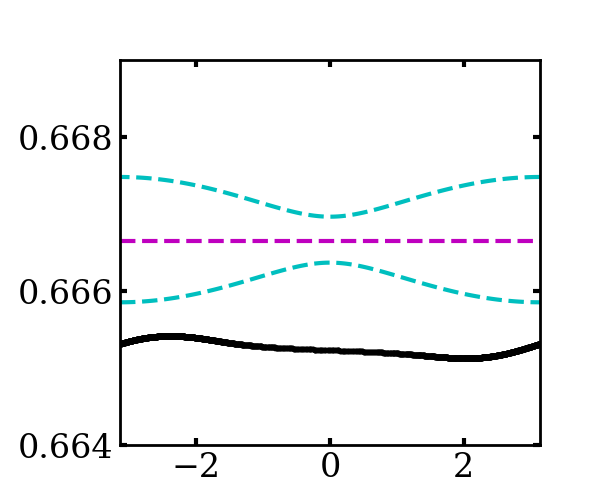

In [110]:
sel = 756
#sel = 300
for i, result in enumerate(results):
    ps = result[1]
    if ps[0] == sel:
        ind = i
print(ind)


sol = results[int(ind)][0]
ps = results[int(ind)][1]
ompval = ps[1]
print(ompval)
indt1 = np.where(sol["t"] > 4.0004e5)[0][0]
indt2 = np.where(sol["t"] > 5e5)[0][0]
#indt2 = np.where(sol["t"] > 5e5)[0][0]
#indt3 = np.where(sol["t"] > 6e6)[0][0]

with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
fig.subplots_adjust(left=0.2)

n = sol["a"][indt1:indt2]**(-3./2)
th2 = (sol["th"][indt1:indt2]-sol["pom"][indt1:indt2])%(2*np.pi)
th2 = th2 - 2*np.pi*(th2>np.pi)
ax.scatter(th2, n,s=10,c="k")#,c=sol["t"][indt1:indt2])

#print(np.average(sol["e"][indt3:]))
TH = np.linspace(-np.pi,np.pi,1000)
NN = np.linspace(.664,.669,1000)
TH,NN = np.meshgrid(TH,NN)
AA = NN**(-2./3)
cs = ax.contour(TH,NN,eq(TH,AA),levels=[-1.075e-7],colors="c")

ax.axhline(y=(2/(3))+ompval/3,c="m",ls="--")

# Data writing/loading

In [116]:
with open(f"/home/astrosun/jtlaune/wc-apsidal-precession/results-mup6e-6-er3bp-ep0_0.025-omp-1e-2_1e-2-tpoutside-discapture.pkl", "wb") as f:
    pickle.dump(results,f)


In [31]:
with open(f"/home/astrosun/jtlaune/wc-apsidal-precession/results-mup6e-6-er3bp-ep0_0.025-omp-1e-2_1e-2-tpoutside-discapture.pkl", "rb") as f:
    results = pickle.load(f)